# ENSAE : Bayesian statistics

 Presented  by :
 - Ali HAIDAR
 - Yunhao CHEN

# SUR Model

The linear SUR model involves a set of regression equations with cross-equation parameter restrictions and correlated error terms having differing variances. Algebraically, the
SUR model is given by:

$$y_j = X_j\beta_j + u_j, j = 1,...m, ~~\text{with}~~ E[u_iu_j^{T}] = \begin{cases} 
- \omega_{ij}I,\ \ \ (i \ne j) \\
- \omega_{i}^2I,\ \ \ (i = j) \\ 
\end{cases}$$

we can model the problem with :
$$ y = X\beta + u$$ 
where,
- $u \sim \mathcal{N}(0,\Omega⊗I)$ 
- $\Omega$ is m × m symmetric matrix with diagonal elements $\{\omega_1^2,...\omega_m^2\}$
- $X$ = diag{$X_1,...X_m$}

we can write the likehood function as :
$$L(y|\beta,\Omega) = \frac{1}{(2\pi)^{\frac{nm}{2}}|\Omega|^{\frac{n}{2}}}\exp[-\frac{1}{2}tr\{R\Omega^{-1}\}] $$
where $R = (r_{ij})$, $r_{ij} = (y_i - X_{i}\beta_i)^T(y_j - X_j\beta_j)$

# Markov chain Monte Carlo Approach

In this approach, we suppose that we don't have a prior knowledge on the parameters. Therefore, we use a Jeffrey's invariant prior :

$$ \pi(\beta,\Omega) = \pi(\beta)\pi(\Omega) ∝ |\Omega|^{-\frac{m+1}{2}} $$ 

Where m is the number of different values of $\beta$.

Using this prior, we can obtain the joint posterior density function :
$$\pi(\beta,\Omega|D) ∝ |\Omega|^{-\frac{n+m+1}{2}}\exp[(-\frac{1}{2}\{\text{tr}( R \Omega^{-1})\}]$$

We can deduce the conditional posteriors $\pi(\beta|\Omega,D)$ and $\pi(\Omega|\beta,D)$:

$$\beta|\Omega,D \sim \mathcal{N}(\hat \beta,\hat \Omega_\beta) ~~\text{and}~~ \Omega|\beta,D \sim IW(R,n)$$

where,

$\hat \beta = \{X^T(\Omega^{-1}⊗I)X\}^{-1}X^{T}(\Omega^{-1}⊗I)y$ 

$\hat \Omega_\beta = (X^{T}(\Omega^{-1}⊗I)X)^{-1}$

We will implement this method using gibbs sampler.

We start by $\beta_{0}$, $\Omega_{0}$.
At each step t :

- We generate a new value $\beta_{t}$ from $\mathcal{N}(\hat \beta_{t-1},\hat \Omega_{t-1})$.
- We generate a new value $\Omega_{t}$ from $IW(R_t,n)$


In [436]:
from utils import generate_SUR, Sampler, DefaultParams
import numpy as np
from numpy.linalg import inv
from scipy.stats import invwishart, invgamma
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal as mvnorm
from scipy.stats import expon
import math
import pandas as pd
sns.set()

import warnings
warnings.filterwarnings("ignore")

In [437]:
# get the default parameters of SUR
params = DefaultParams()
params.print()

beta1 =  [ 3 -2]
beta2 =  [2 1]
omega =  [[ 0.3  -0.15]
 [-0.15  0.2 ]]
number of simulations for each model =  100


In [438]:
class MCMC_Sampler(Sampler):
    def __init__(self, SUR_data, num_iterations=11000, burn_in_steps=1000):
        super().__init__(SUR_data)
        self.num_iterations = num_iterations
        self.burn_in_steps = burn_in_steps

    def _sample_beta(self, omega):
        omega_inv = inv(omega)
        n = params.n
        omega_inv_tensor = np.block([
                        [omega_inv[0,0]*np.eye(n), omega_inv[0,1]*np.eye(n)],
                        [omega_inv[1,0]*np.eye(n), omega_inv[1,1]*np.eye(n)],
        ])
        X = self.SUR_data['X']
        Y = self.SUR_data['Y']
        X_transposed = np.transpose(X)
        beta_hat = inv(X_transposed @ omega_inv_tensor @ X) @ X_transposed @ omega_inv_tensor @ Y
        omega_hat = inv(X_transposed @ omega_inv_tensor @ X)
        beta = np.random.multivariate_normal(mean=beta_hat.reshape(-1,), cov=omega_hat)
        return beta

    def _sample_omega(self, beta):
        y1 = self.SUR_data['Y'][:params.n]
        y2 = self.SUR_data['Y'][params.n:]
        x1 = self.SUR_data['x1']
        x2 = self.SUR_data['x2']
        m1 = y1 - x1 @ beta[:2].reshape(-1,1)
        m2 = y2 - x2 @ beta[2:].reshape(-1,1)
        R = np.array([[(np.transpose(m1) @ m1).item(), (np.transpose(m1) @ m2).item()],
                      [(np.transpose(m2) @ m1).item(), (np.transpose(m2) @ m2).item()]])
        omega = invwishart.rvs(df=params.n, scale=R)
        return omega

    def sample(self):
        beta_simu = []
        omega_simu = []
        omega = np.random.rand(2,2) # initialisation
        for _ in range(self.num_iterations):
            beta = self._sample_beta(omega)
            omega = self._sample_omega(beta)
            beta_simu.append(beta)
            omega_simu.append(omega)
        return np.array(beta_simu[self.burn_in_steps:]), np.array(omega_simu[self.burn_in_steps:])

In [439]:
mcmc_sampler = MCMC_Sampler(SUR_data=generate_SUR())
beta_simu, omega = mcmc_sampler.sample()

beta1 = beta_simu[:,:2]
beta2 = beta_simu[:,2:]

In [440]:
result_mcmc = pd.DataFrame()
result_mcmc['beta11'] = beta1[:,0]
result_mcmc['beta12'] = beta1[:,1]
result_mcmc['beta21'] = beta2[:,0]
result_mcmc['beta22'] = beta2[:,1]
result_mcmc['omega11'] = omega[:,0,0]
result_mcmc['omega12'] = omega[:,0,1]
result_mcmc['omega22'] = omega[:,1,1]
result_mcmc['method'] = 'MCMC'

In [441]:
def plot_beta(beta):
    fig = plt.figure(figsize=(15, 15))
    l = int(np.sqrt(len(beta[:,0])))
    plt.subplot(4, 2, 1)
    plt.plot(beta[:,0], label='beta1_1')
    plt.plot(np.ones(len(beta[:,0]))*params.beta1[0], label='real_beta1_1',linestyle = '-')
    plt.legend()
    plt.subplot(4,2,2)
    plt.hist(beta[:,0],bins = l , label='beta1_1')
    plt.vlines(x=params.beta1[0],ymin=0,ymax=1,label = 'real_beta1_1',color = 'r')
    plt.legend()
    
    plt.subplot(4, 2, 3)
    plt.plot(beta[:,1], label='beta1_2')
    plt.plot(np.ones(len(beta[:,0]))*params.beta1[1], label='real_beta1_2',linestyle = '-')
    plt.legend()
    plt.subplot(4,2,4)
    plt.hist(beta[:,1],bins = l, label='beta1_2')
    plt.vlines(x=params.beta1[1],ymin=0,ymax=1,label = 'real_beta1_2',color = 'r')
    plt.legend()
    
    plt.subplot(4, 2, 5)
    plt.plot(beta[:,2], label='beta2_1')
    plt.plot(np.ones(len(beta[:,2]))*params.beta2[0], label='real_beta2_1',linestyle = '-')
    plt.legend()
    plt.subplot(4,2,6)
    plt.hist(beta[:,2],bins = l, label='beta2_1')
    plt.vlines(x=params.beta2[0],ymin=0,ymax=1,label = 'real_beta2_1',color = 'r')
    plt.legend()
    
    plt.subplot(4, 2, 7)
    plt.plot(beta[:,3], label='beta2_2')
    plt.plot(np.ones(len(beta[:,3]))*params.beta2[1], label='real_beta2_2',linestyle = '-')
    plt.subplot(4,2,8)
    plt.hist(beta[:,3],bins = l, label='beta2_2')
    plt.vlines(x=params.beta2[1],ymin=0,ymax=1,label = 'real_beta2_2',color = 'r')
    plt.legend()
    plt.xlabel("#Iterations")
    plt.title("Gibbs sampler")
    plt.ylim(-3, 4)
    plt.legend()
    plt.show()

In [442]:
def plot_omega(omega):
    fig = plt.figure(figsize=(15, 15))
    l = int(np.sqrt(len(omega[:,0,0])))
    plt.subplot(3, 2, 1)
    plt.plot(omega[:,0,0], label='omega1')
    plt.plot(np.ones(len(omega[:,0,0]))*params.omega[0,0], label='real_omega1_1',linestyle = '-')
    plt.legend()
    
    plt.subplot(3,2,2)
    plt.hist(omega[:,0,0], bins = l, label='omega1')
    plt.vlines(x=params.omega[0,0],ymin=0,ymax=1,label = 'real_omega1_1',color = 'r')
    plt.legend()
    
    
    plt.subplot(3,2,3)
    plt.plot(omega[:,0,1], label='omega1_2')
    plt.plot(np.ones(len(omega[:,0,0]))*params.omega[1,0], label='real_omega1_2',linestyle = '-')
    plt.legend()
    
    plt.subplot(3,2,4)
    plt.hist(omega[:,0,1], bins = l,label='omega1_2')
    plt.vlines(x=params.omega[0,1],ymin=0,ymax=1,label = 'real_omega1_2',color = 'r')
    plt.legend()
    
    plt.subplot(3,2,5)
    plt.plot(omega[:,1,1], label='omega2')
    plt.plot(np.ones(len(omega[:,0,0]))*params.omega[1,1], label='real_omega2_2',linestyle = '-')
    
    plt.subplot(3,2,6)
    plt.hist(omega[:,1,1], bins = l,label='omega2_2')
    plt.vlines(x=params.omega[1,1],ymin=0,ymax=1,label = 'real_omega2_2',color = 'r')
    plt.legend()
    
    plt.xlabel("#Iterations")
    plt.title("Gibbs sampler")
    plt.ylim(-0.1, 0.3)
    plt.legend()
    plt.show()

In [443]:
print(f'Mean: {np.mean(beta1, axis=0)};')
print(f'real: {params.beta1.reshape(-1)};')

Mean: [ 2.9795097  -1.99523961];
real: [ 3 -2];


In [444]:
print(f'Mean: {np.mean(beta2, axis=0)};')
print(f'real: {params.beta2.reshape(-1)};')

Mean: [2.00155972 1.00692983];
real: [2 1];


In [445]:
print(f'Mean: {np.mean(beta1, axis=0)};')
print(f'real: {params.beta1.reshape(-1)};')

Mean: [ 2.9795097  -1.99523961];
real: [ 3 -2];


In [446]:
print(f'Mean: {np.mean(omega, axis=0)};')
print(f'real: {params.omega.reshape(-1)};')

Mean: [[ 0.34590694 -0.04158488]
 [-0.04158488  1.0395377 ]];
real: [ 0.3  -0.15 -0.15  0.2 ];


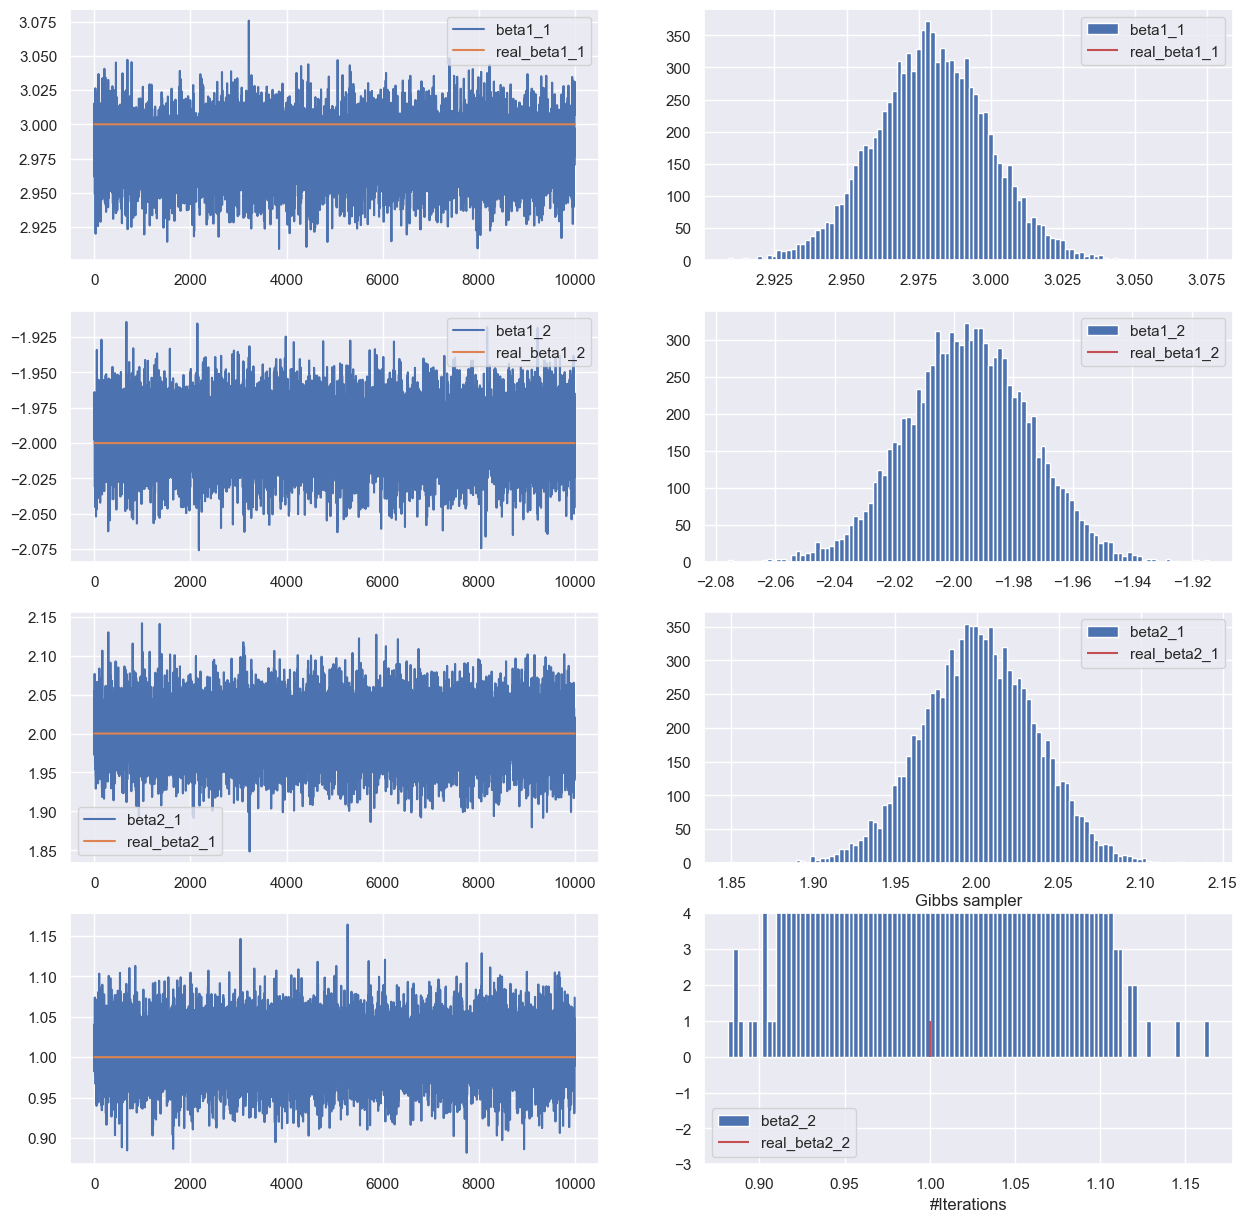

In [447]:
plot_beta(beta=beta_simu)

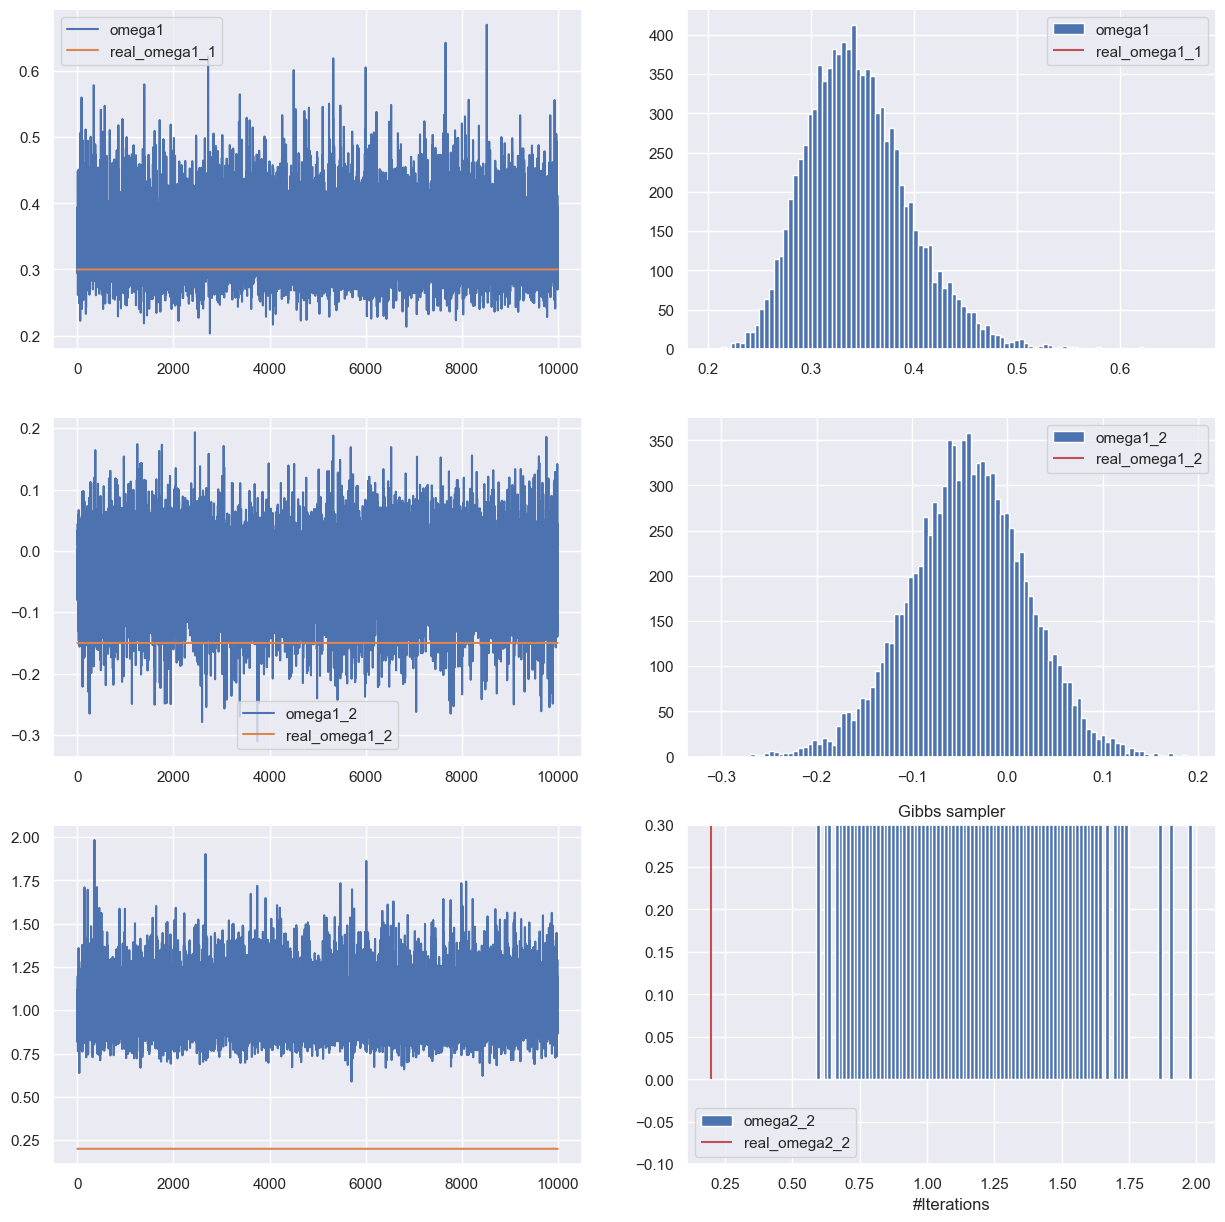

In [448]:
plot_omega(omega=omega)

In [449]:
# def sample_beta(omega, data:generate_SUR):
#     omega_inv = inv(omega)
#     omega_inv_tensor = np.block([
#                     [omega_inv[0,0]*np.eye(params.n), omega_inv[0,1]*np.eye(params.n)],
#                     [omega_inv[1,0]*np.eye(params.n), omega_inv[1,1]*np.eye(params.n)],
#     ])
#     X = data['X']
#     Y = data['Y']
#     X_transposed = np.transpose(X)
#     beta_hat = inv(X_transposed @ omega_inv_tensor @ X) @ X_transposed @ omega_inv_tensor @ Y
#     omega_hat = inv(X_transposed @ omega_inv_tensor @ X)
#     beta = np.random.multivariate_normal(mean=beta_hat.reshape(-1,), cov=omega_hat)
#     return beta
# def sample_omega(beta, data:generate_SUR):
#     y1 = data['Y'][:100]
#     y2 = data['Y'][100:]
#     x1 = data['x1']
#     x2 = data['x2']
#     m1 = y1 - x1 @ params.beta1
#     m2 = y2 - x2 @ params.beta2
#     R = np.array([[(np.transpose(m1) @ m1).item(), (np.transpose(m1) @ m2).item()],
#                   [(np.transpose(m2) @ m1).item(), (np.transpose(m2) @ m2).item()],])
#     omega = invwishart.rvs(df=params.n, scale=R)
#     return omega
# def sample(num_iterations=11000, burn_in_steps=1000):
#     beta_simu = []
#     omega_simu = []
#     # initialisation
#     omega = np.random.rand(2,2)
    
#     for _ in range(num_iterations):
#         beta = sample_beta(omega, data)
#         omega = sample_omega(beta, data)
#         beta_simu.append(beta)
#         omega_simu.append(omega)
    
#     return np.array(beta_simu[burn_in_steps:]), np.array(omega_simu[burn_in_steps:])

# Direct Monte Carlo Approach

In this approach, we apply a DMC on a transformed model.

$$\begin{cases}
y_1 = X_1\beta_1 + e_1 ≡ Z_1b_1 + e_1 \\
y_j = X_j\beta_j + \sum_{l=1}^{j-1}\rho_{jl}(y_l - X_l\beta_l) e_j ≡ Z_jb_j + e_j \\
\end{cases}$$

where the n × (pj + j − 1) matrices $Z_j$ are functions of $\beta_{j-1},...\beta_{1}$ and
$$E[e_{i}e_{j}^T] = \begin{cases}
O, (i \ne j) \\
\sigma_i^2 I, (i = j) \\
\end{cases}$$
and $\Sigma$ = diag{$\sigma_{1}^2,...\sigma_{m}^2$}

Note that, there is a one to one relation between the parameters of the SUR and the model above.

This transformation helps us to do direct Monte Carlo simulations.

The prior density : 

$$\pi(b,\Sigma) ∝ |\Omega(b,\Sigma)|^{-\frac{m+1}{2}}|J| = \prod_{j=1}^{m}(\sigma_j^2)^{-\frac{m+1}{2}}\prod_{j^{'} = 1}^{m-1}(\sigma_{j'}^{2})^{m-j^{'}} = \prod_{j=1}^{m}(\sigma_j^2)^{\frac{m-2j-1}{2}}$$

The joint posterior density is :

$$\pi(b_{j}|b_{j-1},...b_{1},\sigma_j^{2},D) = \mathcal{N}(\hat b_{j}, \sigma_j^{2}(Z_j^{T}Z_j)^{-1})$$

$$\pi(\sigma_{j}^{2}|b_{j-1},...b_{1},D) = IG(\frac{\hat \gamma_{j}}{2},\frac{\hat \nu_{j}}{2})$$

where, 
- $\hat b_{j} = (Z_{j}^TZ_{j})^{-1}Z_{j}^Ty_j$
- $\hat \gamma_{j} = (y_{j} - Z_j\hat b_{j})^{T}(y_{j} - Z_{j}\hat b_j)$
- $\hat \nu_j = n - m - p_j + j + 1$

To simplify the formula, we will focus on the case m = 2 

For m = 2, 

- $b_1 = \beta_1$
- $b_2 = (\beta_2,\rho_{21})$

~
- $Z_1 = X_1$
- $Z_2 = (X_2, y_1 - X_1b_1)$

~
- $\omega_{1}^{2} = \sigma_{1}^{2}$
- $\omega_{2}^{2} = \rho_{21}\sigma_{1}^{2} + \sigma_{2}^{2}$
- $\omega_{12} = \rho_{21}\sigma_{1}^{2}$

~
- $\rho_{21} = \frac{\omega_{12}}{\omega_{1}^2}$

In [450]:
class DMC_Sampler(Sampler):
    def __init__(self, SUR_data, params = DefaultParams(), n_samples=10000) -> None:
        super().__init__(SUR_data)
        self.n_samples = n_samples
        self._params = params
    '''  
    def sample(self):
        y1 = self.SUR_data['Y'][:self._params.n]
        y2 = self.SUR_data['Y'][self._params.n:]
        x1 = self.SUR_data['x1']
        x2 = self.SUR_data['x2']
        b1_hat = inv(np.transpose(x1) @ x1) @ np.transpose(x1) @ y1
        a1 = (params.n - 2) / 2
        scale1 = (np.transpose(y1 - x1 @ b1_hat) @ (y1 - x1 @ b1_hat)).item() / 2
        sigma1 = [invgamma.rvs(a=a1, scale=scale1) for _ in range(self.n_samples)]
        mean1 = b1_hat.reshape(-1,)
        b1 = [np.random.multivariate_normal(mean=mean1, cov=inv(np.transpose(x1) @ x1)*sig1).reshape(-1,1) for sig1 in sigma1]
        z2 = [np.concatenate((x2, (y1-x1@b1_ele)), axis=1) for b1_ele in b1]
        b2_hat = [inv(np.transpose(z2_ele) @ z2_ele) @ np.transpose(z2_ele) @ y2 for z2_ele in z2]
        a2 = (params.n - 1) / 2
        scale2 = [(np.transpose(y2 - z2_ele @ b2_hat_ele) @ (y2 - z2_ele @ b2_hat_ele)).item() / 2 
                    for (z2_ele,b2_hat_ele) in zip(z2,b2_hat)]
        sigma2 = [invgamma.rvs(a=a2, scale=scale2_ele) for scale2_ele in scale2]
        b2 = [np.random.multivariate_normal(mean=b2_hat_ele.reshape(-1,), cov=inv(np.transpose(z2_ele) @ z2_ele)*sig2).reshape(-1,1) 
                for (b2_hat_ele,sig2,z2_ele) in zip(b2_hat,sigma2,z2)]
        
        rho = [ele[-1].item() for ele in b2]
        w11 = np.array(sigma1)
        w12 = np.array([rho_ele * sigma1_ele for (rho_ele, sigma1_ele) in zip(rho, sigma1)])
        w22 = np.array([rho_ele * sigma1_ele + sigma2_ele for (rho_ele, sigma1_ele, sigma2_ele) in zip(rho, sigma1, sigma2)])
        Omega = [np.array([[w11_ele, w12_ele], 
                           [w12_ele, w22_ele]]) for (w11_ele, w12_ele, w22_ele) in zip(w11, w12, w22)]
        beta1 = np.array(b1)
        beta2 = np.array(b2)[:,:2,:]
        return beta1, beta2, np.array(Omega)
    '''
    def sample(self):
        y1 = self.SUR_data['Y'][:self._params.n]
        y2 = self.SUR_data['Y'][self._params.n:]
        x1 = self.SUR_data['x1']
        x2 = self.SUR_data['x2']

        z1 = x1.copy()
        b1_hat = inv(z1.T@z1)@z1.T@y1
        gamma1_hat = ((y1 - z1@b1_hat).T@(y1 - z1@b1_hat)).reshape(-1)
        nu1_hat = self._params.n - 2
      
        #generate sigma1 and b1
        sigma1 = invgamma.rvs(a = nu1_hat/2,scale=gamma1_hat/2,size = self.n_samples)
        b1 = np.array([np.random.multivariate_normal(mean = b1_hat.reshape(-1), cov = sigma1_k*inv(z1.T@z1)) for sigma1_k in  sigma1])

        #generate sigma2 and b2
        z2 = np.array([np.hstack((x2, y1 - x1@b.reshape(-1,1))) for b in b1])
        b2_hat = np.array([inv(z.T@z)@z.T@y2 for z in z2])
        gamma2_hat = np.array([((y2 - z2[i]@b2_hat[i]).T@(y2 - z2[i]@b2_hat[i])).reshape(-1) for i in range(len(b2_hat))])
        nu2_hat = self._params.n - 1
        sigma2 = np.array([invgamma.rvs(a = nu2_hat/2,scale=g/2) for g in gamma2_hat])
        b2 = np.array([np.random.multivariate_normal(mean = b2_hat[i].reshape(-1), cov = sigma2[i]*inv(z2[i].T@z2[i])) for i in  range(len(sigma2))])

        #get the initial parameters
        beta1 = b1
        beta2 = b2[:,:2]
        rho21 = b2[:,-1]
        omega1 = sigma1
        omega2 = rho21*sigma1 + sigma2
        omega1_2 = rho21*sigma1
        omega = np.array([np.array([[o1,o12],[o21,o22]]) for o1,o12,o21,o22 in zip(omega1,omega1_2,omega1_2,omega2)])
        
        return beta1, beta2, omega,sigma1,sigma2
        

In [451]:
DMC_sampler = DMC_Sampler(SUR_data=generate_SUR())
beta1, beta2, omega, sigma1, sigma2 = DMC_sampler.sample()

In [452]:
sigma_sim = np.hstack((sigma1.reshape(-1,1),sigma2.reshape(-1,1)))

In [453]:
result_dmc = pd.DataFrame()
result_dmc['beta11'] = beta1[:,0]
result_dmc['beta12'] = beta1[:,1]
result_dmc['beta21'] = beta2[:,0]
result_dmc['beta22'] = beta2[:,1]
result_dmc['omega11'] = omega[:,0,0]
result_dmc['omega12'] = omega[:,0,1]
result_dmc['omega22'] = omega[:,1,1]
result_dmc['method'] = 'DMC'

In [454]:
print(f'Mean: {np.mean(beta1, axis=0)};')
print(f'real: {params.beta1.reshape(-1)};')

Mean: [ 3.02931611 -2.01322127];
real: [ 3 -2];


In [455]:
print(f'Mean: {np.mean(beta2, axis=0)};')
print(f'real: {params.beta2.reshape(-1)};')

Mean: [1.92599336 1.01874762];
real: [2 1];


In [456]:
print(f'Mean: {np.mean(omega, axis=0)};')
print(f'real: {params.omega};')

Mean: [[ 0.36873115 -0.17221241]
 [-0.17221241  0.9742734 ]];
real: [[ 0.3  -0.15]
 [-0.15  0.2 ]];


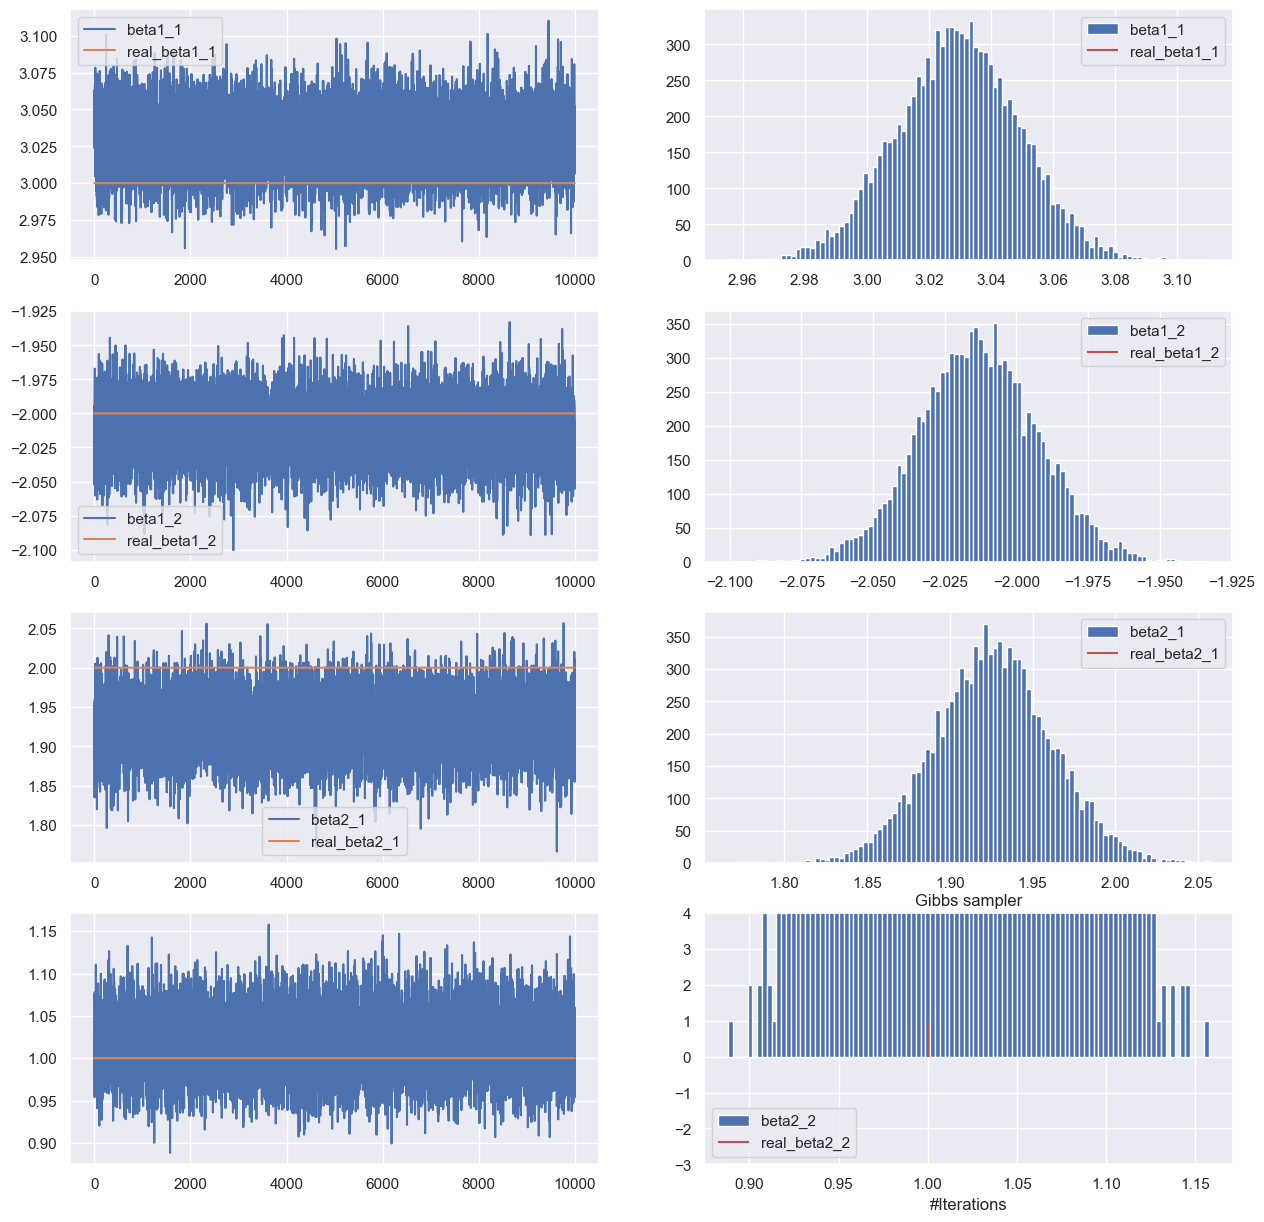

In [457]:
beta = np.hstack((beta1.reshape(-1,2),beta2.reshape(-1,2)))
plot_beta(beta)

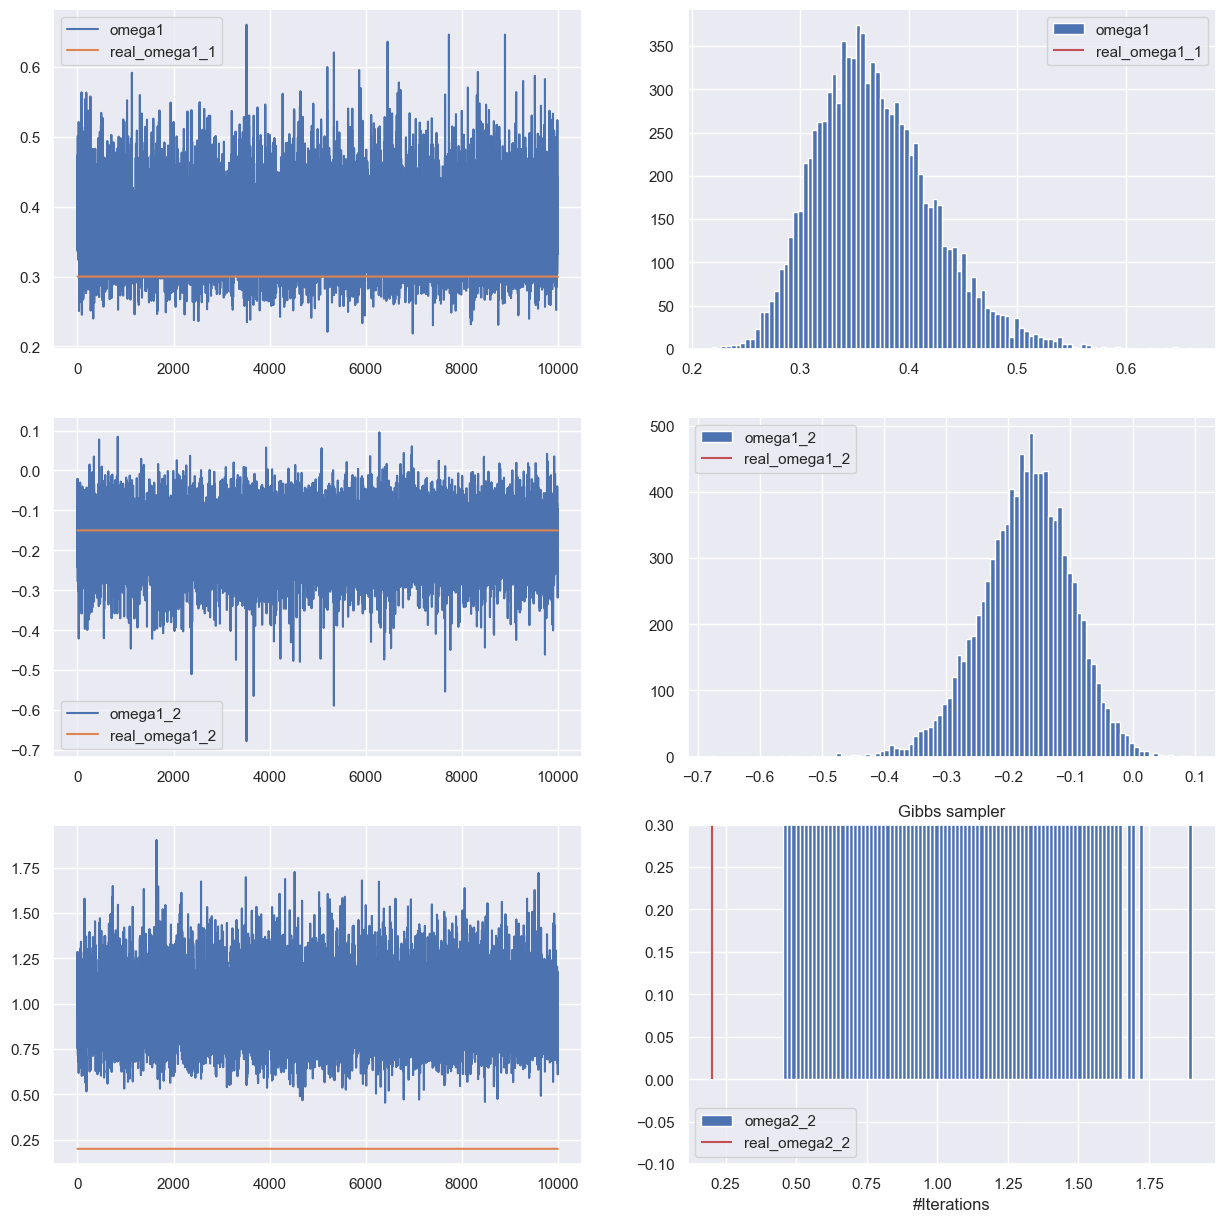

In [458]:
plot_omega(omega)

# Direct Monte Carlo Importance Sampling Approach

We use again the transformed model but with hierarchical prior structure.
$$\pi(\beta,\Omega,\lambda) = \pi(\beta|\lambda)\pi(\Omega)\pi(\lambda)$$

- $\pi(\beta|\lambda) ∝ \exp\{-\frac{1}{2}(\beta-\beta_0)^TΓ(\lambda,A)(\beta-\beta_0)\}$
- $\pi(\Omega) ∝ |\Omega|^{-\frac{m+1}{2}}$
- $\pi(\lambda) = \prod_{j=1}^{m}\pi(\lambda_{j}) ∝ \prod_{j=1}^{m}(\lambda_j)^{a_0-1}\exp\{-\lambda_j/b_0\}$

The conditional posterior probabilities: 

- $\pi(b_j|b_{j-1}...,b_1,\sigma_{j}^2,\lambda,D) = \mathcal{N}(\hat b_{j},\sigma_{j}^2(Z_{j}^{T}Z_{j}+\gamma_{j}D_j)^{-1})$
- $\pi(\sigma_{j}^{2}|b_{j-1},...b_{1},\lambda,D) = IG(\hat a_{j}/2, \hat h_{j}/2)$

With,

- $\hat b_{j} = (Z_{j}^TZ_j + \gamma_jD_j)^{-1}[(Z_j^TZ_j)^{-1}\tilde b + \lambda_jD_jb_0 ]$
- $\tilde b_{j} = (Z_{j}^{T}Z_{j})^{-1}Z_{j}^{T}y_{j}$
- $\hat a_{j} = n - m - 2a_{0} + 2j +1$
- $\hat h_{j} = \gamma_{j}/b_{0} + (n-p+j-1)\hat s_{j}^{2} + (\hat b_{j} - b_{0j})^T(Z_{j}^TZ_{j} + \gamma_{j}D_{j})^{-1}(\hat b_{j} - b_{0j})$
- $\hat s_{j}^2 = (y_j - Z_j\tilde b_{j})^{T}(y_j - Z_j\tilde b_j)/(n-p_j+j-1)$ 

To generate $\lambda$, we will use importance sampling :
$$w_{k} = \frac{\pi(b^{(k)},\Sigma^{(k)},\lambda^{(k)}|y)}{\pi(b^{(k)},\Sigma^(k)|\lambda^{(k)},y)\pi(\lambda^{(k)})^{s}}$$

For simplicity, we will consider the case m = 2

Let us suppose that $\pi_s$ as inverse gamma of parameter (5,0.005)

In [459]:
class DMC_IS_Sampler(Sampler):
    def __init__(self, SUR_data, params = DefaultParams(), n_samples=1000) -> None:
        super().__init__(SUR_data)
        self.n_samples = n_samples
        self._params = params
      
     
     
    def L(self,y1,y2,b1,b2,z1,z2,sigma1,sigma2):
        likehood = []
        pi = np.arccos(-1)
        for z2_i,b1_i,b2_i,sigma1_i,sigma2_i in zip(z2,b1,b2,sigma1,sigma2):
            f1 = ((1/((2*pi*sigma1_i)**(self._params.n)))*np.exp(-(y1-z1@b1_i).T@(y1-z1@b1_i)/(2*sigma1_i)))
            f2 = ((1/((2*pi*sigma2_i)**(self._params.n)))*np.exp(-(y2-z2_i@b2_i).T@(y2-z2_i@b2_i)/(2*sigma2_i)))
            likehood.append(f2[0]*f1[0])
        return np.array(likehood)
    
    def pi_s(self,lamda):
        l = invgamma.pdf(x = lamda[:,0], a=1,scale = 0.001)
        r = invgamma.pdf(x = lamda[:,1], a=1,scale = 0.001)
        return l*r
        

    def prior(self,b1,b2,sigma1,sigma2,lamda):
        a0 = 5
        b0 = 0.005
        b01 = np.random.rand(2).reshape(-1,1)
        b02 = np.append(np.random.rand(2),0).reshape(-1,1)
        A11 = np.array([[0.1,0],[0,0.2]])
        A12 = np.array([[0.2,0],[0,0.3]])
        A21 = np.array([[0.2,0],[0,0.3]])
        A22 = np.array([[0.5,0],[0,0.2]])
        gamma_1 = lamda[:,0]*sigma1
        gamma_2 = lamda[:,1]*sigma2
        
        f1 = (sigma1**(1/2 + a0 -2))*(gamma_1**(a0-1))*np.exp(-gamma_1/(sigma1*b0))
        f2 = (sigma2**(1/2 + a0 -1))*(gamma_2**(a0-1))*np.exp(-gamma_2/(sigma2*b0))
        f3 = 1
        return f1*f2*f3
    
    
    def importance_weights(self,y1,y2,b1,b2,z1,z2,sigma1,sigma2,lamda,posterior_such_lamda):
        return (L(y1,y2,b1,b2,z1,z2,sigma1,sigma2)*prior(b1,b2,sigma1,sigma2,lamda))/(pi_s(lamda)*posterior_such_lamda)
     
        
    def sample(self):
       
        SUR_data = generate_SUR()
        y1 = self.SUR_data['Y'][:self._params.n]
        y2 = self.SUR_data['Y'][self._params.n:]
        x1 = self.SUR_data['x1']
        x2 = self.SUR_data['x2']
        a0 = 5
        b0 = 0.005


        b01 = np.random.rand(2).reshape(-1,1)
        b02 = np.append(np.random.rand(2),0).reshape(-1,1)

        A11 = np.array([[0.1,0],[0,0.2]])
        A12 = np.array([[0.2,0],[0,0.3]])
        A21 = np.array([[0.2,0],[0,0.3]])
        A22 = np.array([[0.5,0],[0,0.2]])

        W1 = A11
        W2 = A22 - A12@(inv(A11))@A21 
        #generate lamda
        lamda = invgamma.rvs(a=1,scale = 0.001,size=(self.n_samples,2))
        
        gamma = lamda.copy() # How can we calculate the gamma if we don't have sigma ?

        #generate sigma1
        z1 = x1.copy()
        a1_hat = self._params.n  - 2*a0 + 1
        b1_tilde = inv(z1.T@z1)@z1.T@y1
        d1 = W1
        s1_hat = (((y1 - z1@b1_tilde).T@(y1 - z1@b1_tilde))/(self._params.n - 2))[0]
        b1_hat = np.array([inv(z1.T@z1+g*d1)@(inv(z1.T@z1)@b1_tilde + l*d1@(b0*np.ones(2).reshape(-1,1))) for g,l in zip(gamma[:,0],lamda[:,0])])
        h1_tilde = np.array([(g/b0 + (self._params.n -2)*s1_hat + (b1-b01).T@inv(z1.T@z1+l*d1)@(b1 - b01))[0] for g,b1,l in zip(gamma[:,0],b1_hat,lamda[:,0])])
        sigma1 = np.array([invgamma.rvs(a=a1_hat/2,scale = h/2) for  h in h1_tilde])
        sigma1_pdf = np.array([invgamma.pdf(x=s,a=a1_hat/2,scale = h/2) for  h,s in zip(h1_tilde,sigma1)])
        
        #generate b1
        b1 = np.array([np.random.multivariate_normal(mean = b1_hat_i.reshape(-1), cov = sigma1_i*inv(z1.T@z1 + g*d1)) for b1_hat_i,sigma1_i,g in zip(b1_hat,sigma1, gamma[:,0])])        
        b1_pdf = np.array([mvnorm.pdf(x =b1_i, mean = b1_hat_i.reshape(-1), cov = sigma1_i*inv(z1.T@z1 + g*d1)) for b1_i,b1_hat_i,sigma1_i,g in zip(b1,b1_hat,sigma1, gamma[:,0])])

        #generate sigma2
        z2 = np.array([np.hstack((x2, y1 - x1@b.reshape(-1,1))) for b in b1])
        a2_hat = self._params.n -2*a0  +1
        b2_tilde = np.array([inv(z.T@z)@z.T@y2 for z in z2])
        d2 = np.pad(W2,[(0,1),(0,1)])
        s2_hat = np.array([(((y2 - z@b).T@(y2 - z@b))/(self._params.n - 1))[0] for z,b in zip(z2,b2_tilde)])
        b2_hat = np.array([inv(z.T@z+g*d2)@(inv(z.T@z)@b + l*d2@(b0*np.ones(3).reshape(-1,1))) for z,g,b,l in zip(z2,gamma[:,1],b2_tilde,lamda[:,1])])
        h2_tilde = np.array([(g/b0 + (self._params.n -1)*s2 + (b2-b02).T@inv(z.T@z+g*d2)@(b2 - b02))[0] for g,b2,s2,z in zip(gamma[:,1],b2_hat,s2_hat,z2)])
        sigma2 = np.array([invgamma.rvs(a=a2_hat/2,scale = h2/2) for  h2 in h2_tilde])
        sigma2_pdf = np.array([invgamma.pdf(x=s,a=a2_hat/2,scale = h/2) for  h,s in zip(h2_tilde,sigma2)])
        
        #generate b2
        b2 = np.array([np.random.multivariate_normal(mean = b2_hat_i.reshape(-1), cov = sigma2_i*inv(z.T@z + g*d2)) for b2_hat_i,sigma2_i,g,z in zip(b2_hat,sigma2, gamma[:,1],z2)])
        b2_pdf = np.array([mvnorm.pdf(x =b2_i,mean = b2_hat_i.reshape(-1), cov = sigma2_i*inv(z.T@z + g*d2)) for b2_i,b2_hat_i,sigma2_i,g,z in zip(b2,b2_hat,sigma2, gamma[:,1],z2)])
        
        #get the initial parameters
        beta1 = b1
        beta2 = b2[:,:2]
        rho21 = b2[:,-1]
        omega1 = sigma1
        omega2 = rho21*sigma1 + sigma2
        omega1_2 = rho21*sigma1
        omega = np.array([np.array([[o1,o12],[o21,o22]]) for o1,o12,o21,o22 in zip(omega1,omega1_2,omega1_2,omega2)])
        posterior_such_lamda = sigma1_pdf.reshape(-1)*sigma2_pdf.reshape(-1)*b1_pdf*b2_pdf
        
        return beta1, beta2, omega, lamda

In [460]:
DMC_IS_sampler = DMC_IS_Sampler(SUR_data=generate_SUR())
beta1, beta2, omega, lamda = DMC_IS_sampler.sample()

In [461]:
print(f'Mean: {np.mean(beta1, axis=0)};')
print(f'real: {params.beta1.reshape(-1)};')

Mean: [-0.0001268  -0.00052654];
real: [ 3 -2];


In [462]:
print(f'Mean: {np.mean(beta2, axis=0)};')
print(f'real: {params.beta2.reshape(-1)};')

Mean: [-0.00117609  0.00053787];
real: [2 1];


In [463]:
print(f'Mean: {np.mean(omega, axis=0)};')
print(f'real: {params.omega};')

Mean: [[3.47406315e-01 1.46815615e-04]
 [1.46815615e-04 1.26823040e+00]];
real: [[ 0.3  -0.15]
 [-0.15  0.2 ]];


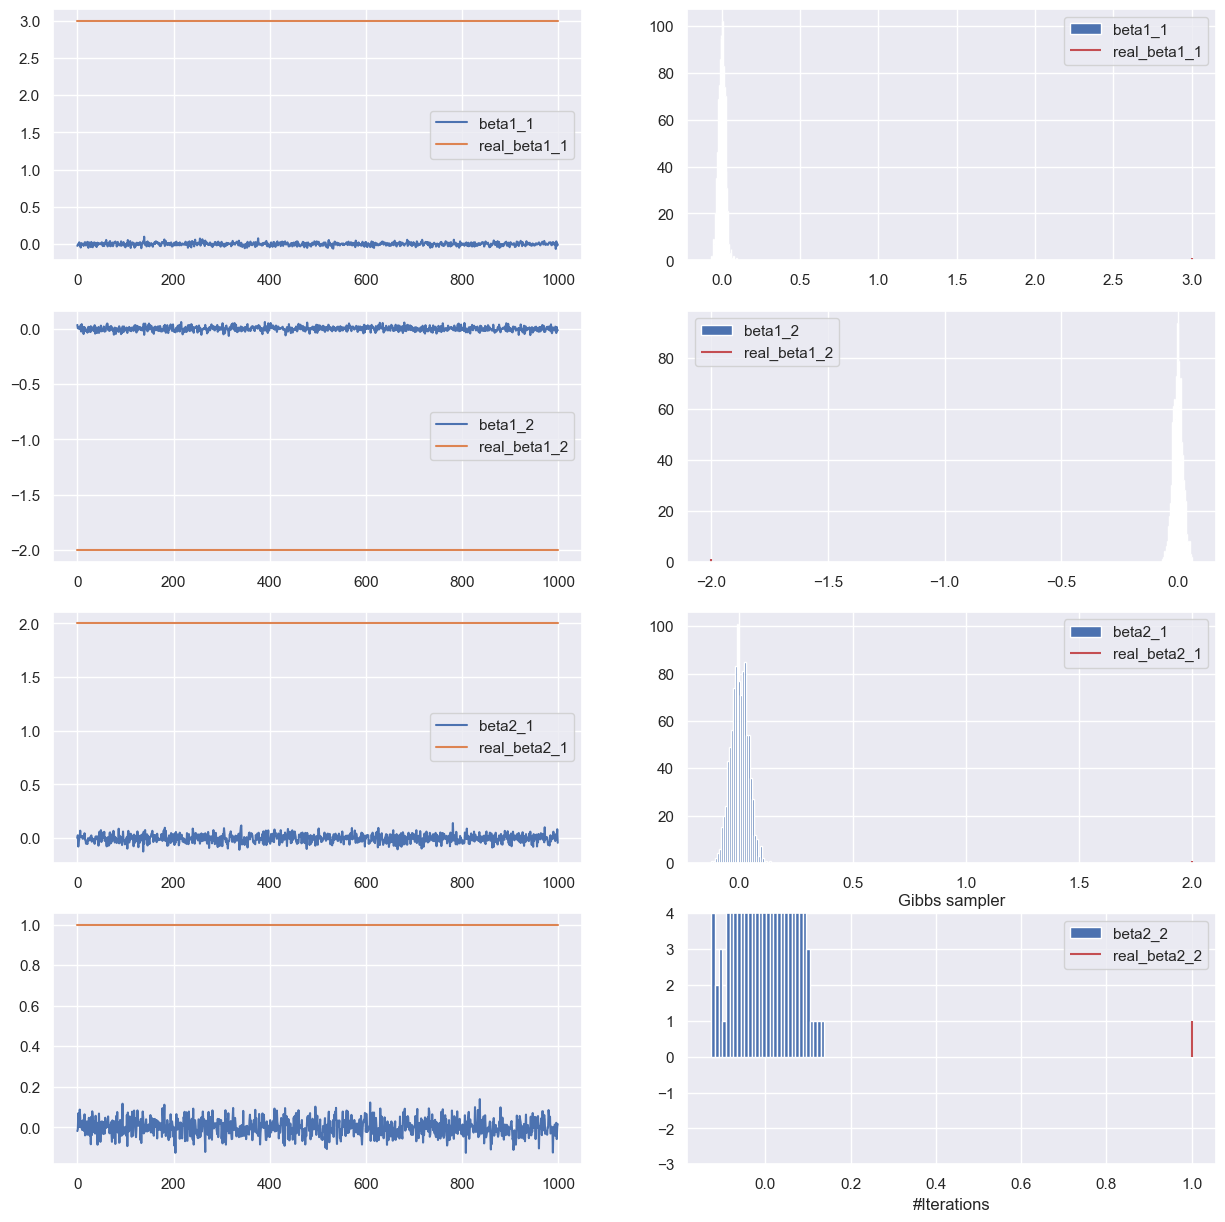

In [464]:
beta = np.hstack((beta1.reshape(-1,2),beta2.reshape(-1,2)))
plot_beta(beta)

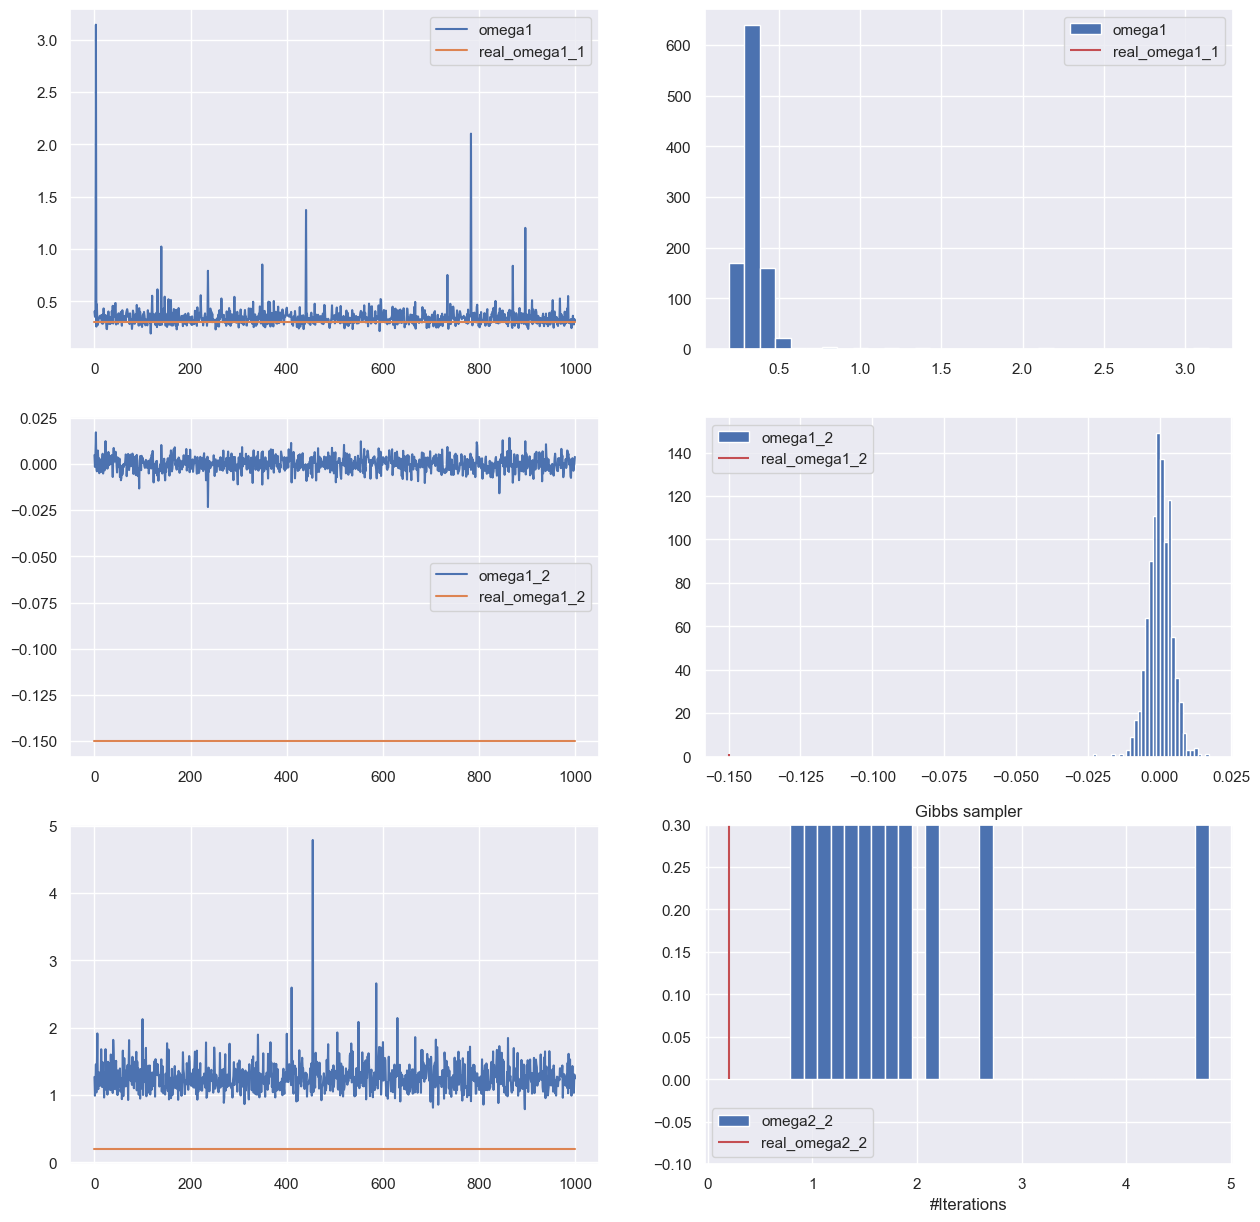

In [465]:
plot_omega(omega)

# Direct Monte Carlo Importance Sampling Approach Based On a Posterior Of Degree Of Freedom V

In [466]:
def multivariatet(mu,Sigma,N,M):
    '''
    Output:
    Produce M samples of d-dimensional multivariate t distribution
    Input:
    mu = mean (d dimensional numpy array or scalar)
    Sigma = scale matrix (dxd numpy array)
    N = degrees of freedom
    M = # of samples to produce
    '''
    d = len(Sigma)
    g = np.tile(np.random.gamma(N/2.,2./N,M),(d,1)).T
    Z = np.random.multivariate_normal(np.zeros(d),Sigma,M)
    return mu + Z/np.sqrt(g)

In [467]:
class DMC_IS_Sampler_V(Sampler):
    def __init__(self, SUR_data, params = DefaultParams(), n_samples=10000) -> None:
        super().__init__(SUR_data)
        self.n_samples = n_samples
        self._params = params
      
    def h(self,v,n):
        pi = np.arccos(-1)
        return (v**(v/2))*(v+n/2)/(pi)*math.gamma(v/2) 
     
    def L(self,y1,y2,b1,b2,z1,z2,v,sigma1,sigma2,n):
        likehood = []
        pi = np.arccos(-1)
        for z2_i,b1_i,b2_i,sigma1_i,sigma2_i,v_i in zip(z2,b1,b2,sigma1,sigma2,v):
            f1 = (self.h(v_i,n)/(sigma1_i**(n/2)))*((v_i + ((y1 - z1@b1_i.reshape(-1,1)).T@(y1-z1@b1_i.reshape(-1,1)))/sigma1_i)**(-(n+v_i)/2))
            f2 = (self.h(v_i,n)/(sigma2_i**(n/2)))*((v_i + ((y2 - z2_i@b2_i.reshape(-1,1)).T@(y2-z2_i@b2_i.reshape(-1,1)))/sigma2_i)**(-(n+v_i)/2))
            likehood.append(f1[0][0]*f2[0][0])
        
        return np.array(likehood)
    
    
    def posterior(self,y1,y2,b1, b2, sigma1, sigma2, n, q1, q2, v, z1, z2):
        f = []
        for b1_i,b2_i,sigma1_i,sigma2_i,v_i,z2_i in zip(b1,b2,sigma1,sigma2,v,z2):
            f1 = (sigma1_i**(-(n+q1)/2))*(v_i + (((y1-z1@b1_i.reshape(-1,1)).T@(y1-z1@b1_i.reshape(-1,1)))/(sigma1_i))**(-(n+v_i)/2))
            f2 = (sigma2_i**(-(n+q2)/2))*(v_i + (((y2-z2_i@b2_i.reshape(-1,1)).T@(y2-z2_i@b2_i.reshape(-1,1)))/(sigma2_i))**(-(n+v_i)/2))
            
            f.append(f1[0][0]*f2[0][0])
        return np.array(f)
    

    def prior(self,b1,b2,q1,q2,sigma1,sigma2,v):
        fv = expon(3).pdf(v)
        f1 = sigma1**(-q1/2)
        f2 = sigma2**(-q2/2)
        return f1*f2*fv
    
    
    def importance_weights(self,y1,y2,z1,z2,b1,b2,sigma1,sigma2,n,q1,q2,v):
        prior_s = self.prior(b1,b2,q1,q2,sigma1,sigma2,v) 
        post_s = self.posterior(y1,y2,b1, b2, sigma1, sigma2, n, q1, q2, v, z1, z2) + 0.00001
        likehood = self.L(y1,y2,b1,b2,z1,z2,v,sigma1,sigma2,n)
       
        w = prior_s*likehood/post_s
        w = w/(np.sum(w))
        return w
     
        
    def sample(self):
       
        SUR_data = generate_SUR()
        y1 = self.SUR_data['Y'][:self._params.n]
        y2 = self.SUR_data['Y'][self._params.n:]
        x1 = self.SUR_data['x1']
        x2 = self.SUR_data['x2']

        #generate v from  a prior exponential
        v = []
        for i in range(self.n_samples):
            y = np.random.exponential(3)
            while(y<2):
                y = np.random.exponential(3)
            v.append(y)
        v = np.array(v)

        #generate sigma1
        z1 = x1.copy()
        b1_hat = inv(z1.T@z1)@z1.T@y1
        p1_tilde = 2
        v1_hat  = self._params.n - 2 +  v
        s1 = ((y1 - z1@b1_hat).T@(y1 - z1@b1_hat)/(self._params.n - p1_tilde))[0][0]
        v1_tilde = self._params.n - p1_tilde
        q1 = 1 

        temp_sigma1 = np.array([np.random.beta((v_i-q1+2)/2,(self._params.n + q1 - p1_tilde -2)/2) for v_i in v])
        temp_sigma1 = (temp_sigma1)/(1-temp_sigma1) 
        sigma1 = (temp_sigma1/v)*(v1_tilde*s1)             
        sigma1_tilde = ((v*sigma1 + (v1_hat - v)*s1)/v1_hat)

        #generate b1
        b1 = np.array([multivariatet(b1_hat.reshape(-1),sigma*inv(z1.T@z1),v1_tilde,1) for sigma  in sigma1_tilde]).reshape(-1,2)

        #generate sigma2
        q2 = 1
        p2_tilde = 3
        v2_hat = self._params.n - p2_tilde + v
        z2 = np.array([np.hstack((x2, y1 - x1@(b.reshape(-1,1)))) for b in b1])
        b2_hat = np.array([inv(z.T@z)@z.T@y2 for z in z2])
        s2 = np.array([((y2 - z@b).T@(y2 - z@b)/(self._params.n - p2_tilde))[0][0] for b,z in zip(b2_hat,z2)])
        v2_tilde = self._params.n - p2_tilde

        temp_sigma2 = np.array([np.random.beta((v_i-q2+2)/2,(self._params.n + q2 - p2_tilde -2)/2) for v_i in v])
        temp_sigma2 = (temp_sigma2)/(1-temp_sigma2) 
        sigma2 = (temp_sigma2/v)*(v2_tilde*s2)             
        sigma2_tilde = ((v*sigma2 + (v2_hat - v)*s2)/v2_hat)

        #generate b2
        b2 = np.array([multivariatet(b.reshape(-1),sigma*inv(z.T@z),v2_tilde,1) for sigma,b,z  in zip(sigma2_tilde,b2_hat,z2)]).reshape(-1,3)


        beta1 = b1
        beta2 = b2[:,:2]
        rho21 = b2[:,-1]
        omega1 = sigma1
        omega2 = rho21*sigma1 + sigma2
        omega1_2 = rho21*sigma1
        omega = np.array([np.array([[o1,o12],[o21,o22]]) for o1,o12,o21,o22 in zip(omega1,omega1_2,omega1_2,omega2)])

        w = self.importance_weights(y1,y2,z1,z2,b1,b2,sigma1,sigma2,self._params.n,q1,q2,v)
        
        return beta1, beta2, omega, w

In [468]:
DMC_IS_sampler_V = DMC_IS_Sampler_V(SUR_data=generate_SUR())
beta1, beta2, omega, w = DMC_IS_sampler_V.sample()

In [469]:
result_dmc_is = pd.DataFrame()
result_dmc_is['beta11'] = beta1[:,0]
result_dmc_is['beta12'] = beta1[:,1]
result_dmc_is['beta21'] = beta2[:,0]
result_dmc_is['beta22'] = beta2[:,1]
result_dmc_is['omega11'] = omega[:,0,0]
result_dmc_is['omega12'] = omega[:,0,1]
result_dmc_is['omega22'] = omega[:,1,1]
result_dmc_is['method'] = 'DMC-IS'

In [470]:
print(f'Mean: {np.mean(beta1, axis=0)};')
print(f'real: {params.beta1.reshape(-1)};')

Mean: [ 2.99423578 -1.99279804];
real: [ 3 -2];


In [471]:
print(f'Mean: {np.mean(beta2, axis=0)};')
print(f'real: {params.beta2.reshape(-1)};')

Mean: [1.97816026 0.97664042];
real: [2 1];


In [472]:
print(f'Mean: {np.mean(omega, axis=0)};')
print(f'real: {params.omega};')

Mean: [[ 0.39588113 -0.24937324]
 [-0.24937324  1.34530399]];
real: [[ 0.3  -0.15]
 [-0.15  0.2 ]];


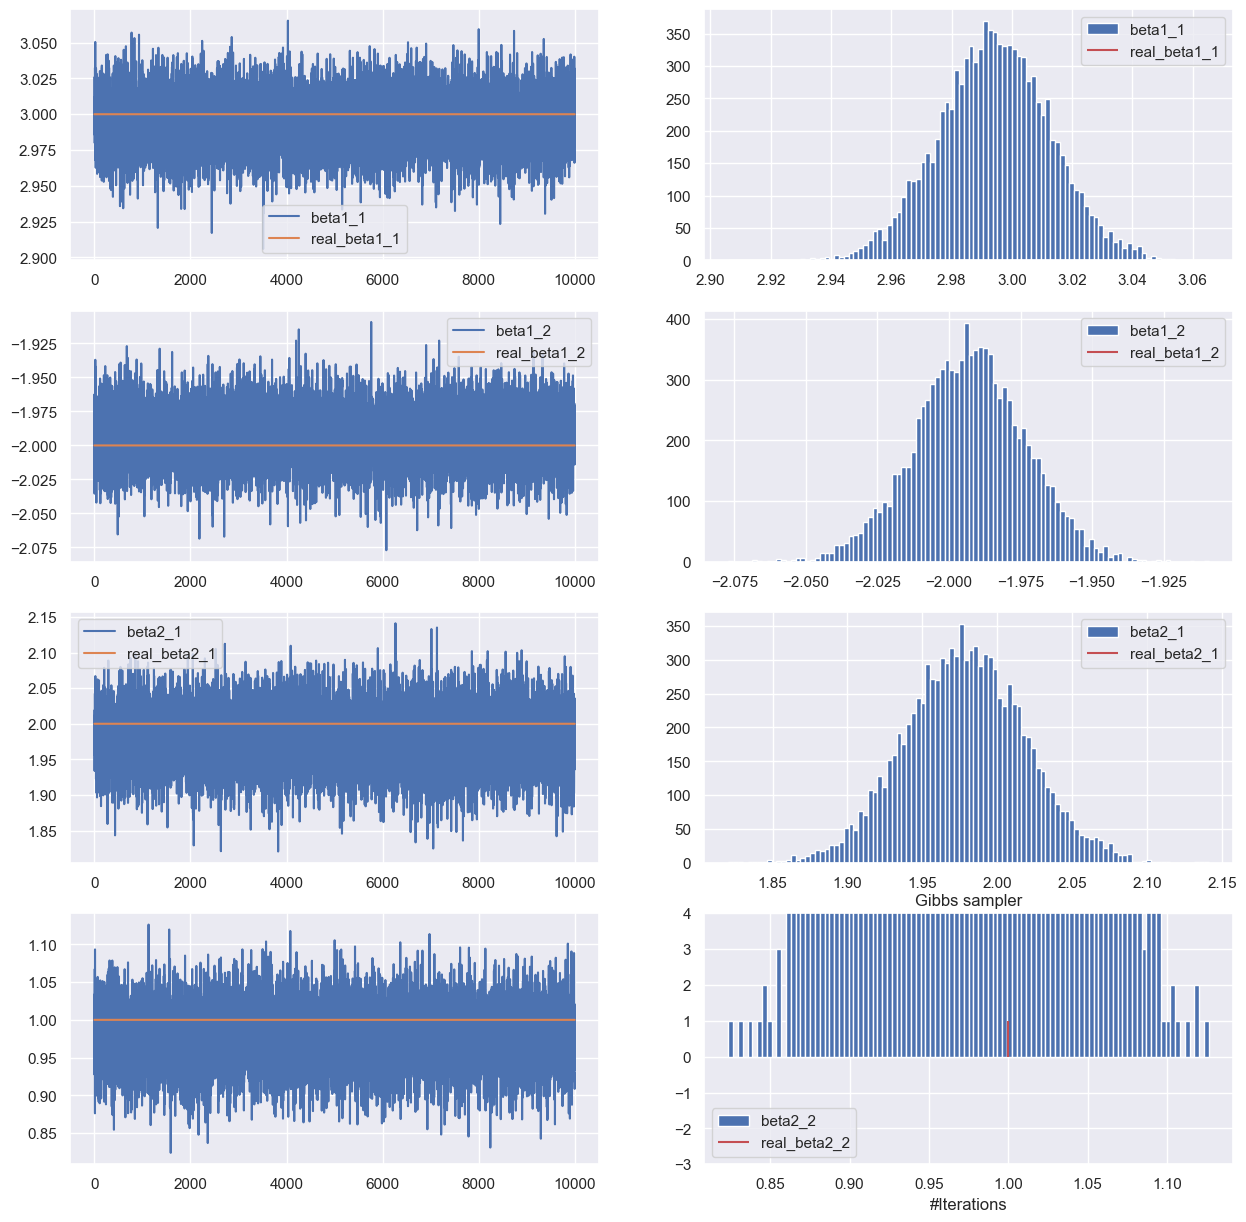

In [473]:
beta = np.hstack((beta1.reshape(-1,2),beta2.reshape(-1,2)))
plot_beta(beta)

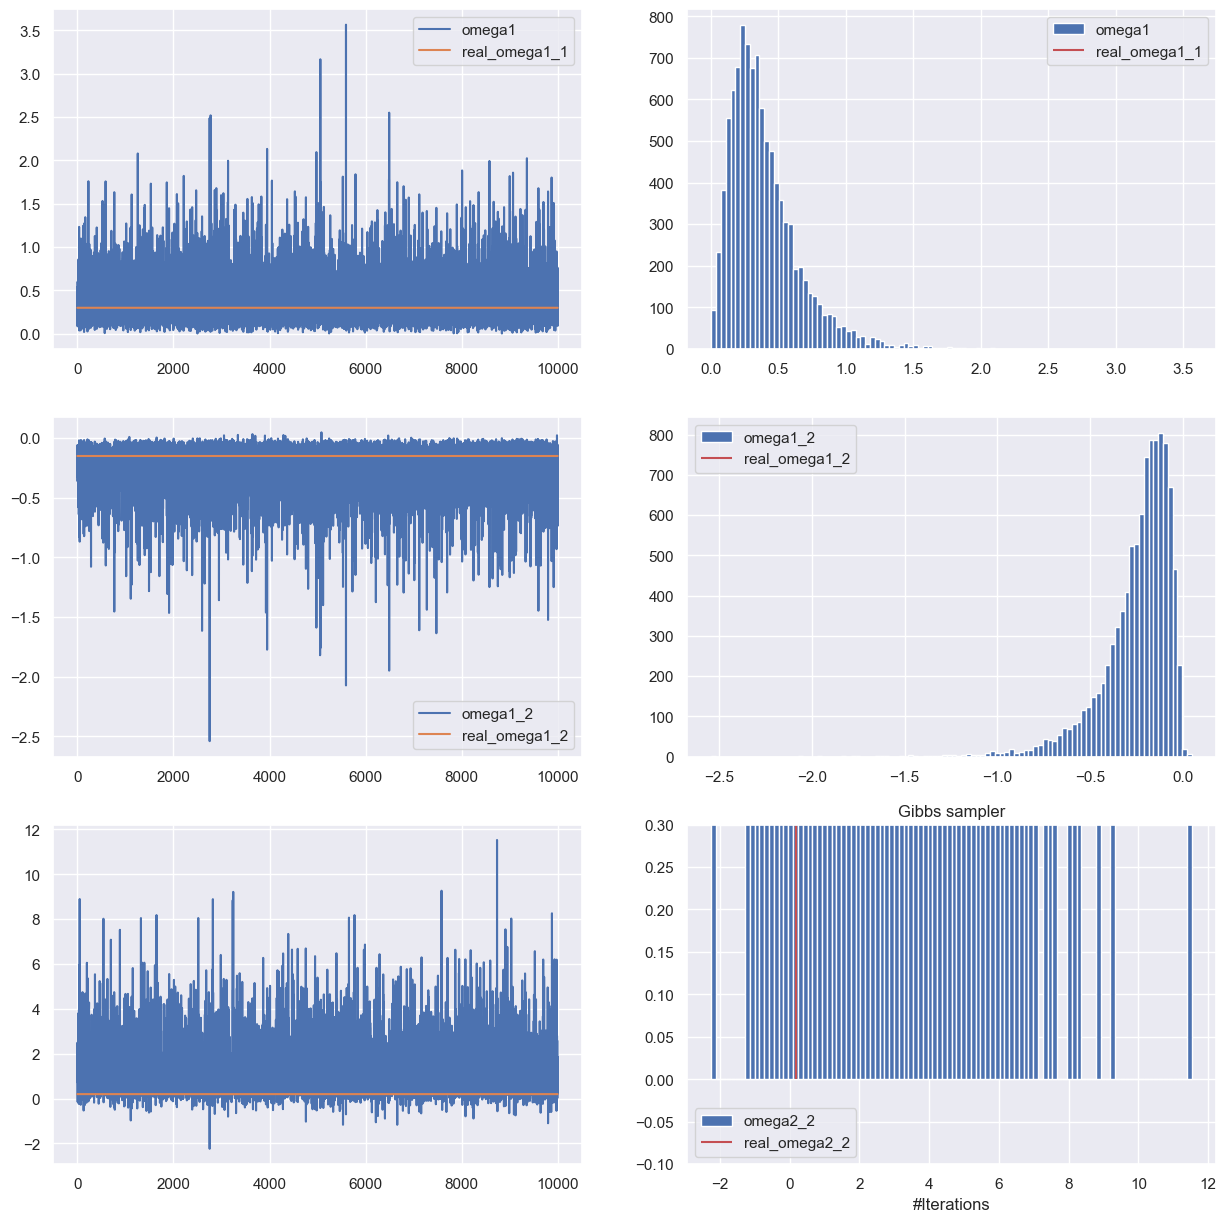

In [474]:
plot_omega(omega)

In [475]:
result = pd.concat([result_mcmc,result_dmc,result_dmc_is])

In [494]:
result.head()

,beta11,beta12,beta21,beta22,omega11,omega12,omega22,method
0,3.007576,-1.986361,2.028340,1.001010,0.356275,-0.080158,1.025416,MCMC
1,2.994172,-1.973376,1.972726,1.021514,0.322578,0.002480,0.817292,MCMC
2,2.986009,-1.997657,2.014078,0.982277,0.312773,-0.061520,0.902812,MCMC
3,3.015337,-1.963924,2.023963,1.014266,0.393835,-0.078480,1.115494,MCMC
4,2.961792,-1.971715,2.013641,1.040556,0.340020,-0.000436,1.119196,MCMC


In [499]:
params.beta1.reshape(-1)

array([ 3, -2])

In [490]:
result[['method','beta11','beta12']].groupby(['method']).agg(['mean', 'std'])

beta11              beta12          
            mean       std      mean       std
method                                        
DMC     3.029316  0.019871 -2.013221  0.020750
DMC-IS  2.994236  0.018490 -1.992798  0.019509
MCMC    2.979510  0.019834 -1.995240  0.020679

In [500]:
params.beta2.reshape(-1)

array([2, 1])

In [491]:
result[['method','beta21','beta22']].groupby(['method']).agg(['mean', 'std'])

beta21              beta22          
            mean       std      mean       std
method                                        
DMC     1.925993  0.035690  1.018748  0.036061
DMC-IS  1.978160  0.040391  0.976640  0.039024
MCMC    2.001560  0.034422  1.006930  0.032685

In [501]:
params.omega

array([[ 0.3 , -0.15],
       [-0.15,  0.2 ]])

In [495]:
result[['method','omega11','omega12','omega22']].groupby(['method']).agg(['mean', 'std'])

omega11             omega12             omega22          
            mean       std      mean       std      mean       std
method                                                            
DMC     0.368731  0.054247 -0.172212  0.073248  0.974273  0.181420
DMC-IS  0.395881  0.269079 -0.249373  0.195339  1.345304  1.085680
MCMC    0.345907  0.050782 -0.041585  0.062349  1.039538  0.154963